In [1]:
import tensorflow as tf

In [ ]:
# adaptations for running Tensorflow on GeForce RTX 2080
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [ ]:
tf.test.is_gpu_available()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, Dropout, UpSampling2D, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
import PIL
from PIL import Image

In [7]:
# Loss function for the network (based on SSIM)
def custom_ssim(y_actual, y_predicted):
    y_actual = (1+y_actual)/2
    y_predicted = (1+y_predicted)/2
    return 1 - tf.image.ssim(y_actual, y_predicted, max_val=1)

In [8]:
# Training and test parameters
num_train = 180 # number of images used in training
num_test = 16 # number of images used in testing

In [9]:
# Loading data for training
xtrain_aux = np.zeros((num_train, 256, 256, 1)) # array with degraded images for training
ytrain_aux = np.zeros((num_train, 256, 256, 1)) # array with non-degraded images for training

# Images degraded by sigma = 3 and dimension = (2, 14) (gaussian blur)
for i in range (num_train):
    xtrain_aux[i, :, :, 0] = np.load('dataset196_gray/sigma3(2, 14)/arrays/' + str(i+1) + '.npy')
    ytrain_aux[i, :, :, 0] = np.load('dataset196_gray/original/arrays/' + str(i+1) + '.npy')

In [10]:
# Normalizaing data
xtrain_aux = xtrain_aux/(xtrain_aux.max())
ytrain_aux = ytrain_aux/(ytrain_aux.max())

In [11]:
# Range of data: -1 to 1
xtrain = 2*xtrain_aux - 1
ytrain = 2*ytrain_aux - 1

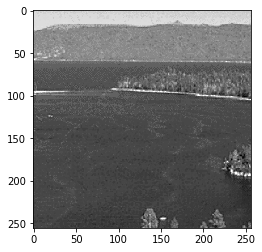

In [12]:
plt.imshow(ytrain_aux[56, :, :, 0], cmap='gray')

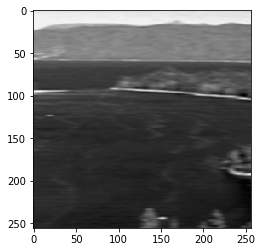

In [13]:
plt.imshow(xtrain_aux[56, :, :, 0], cmap='gray')

In [14]:
# Loading data for testing
xtest_aux = np.zeros((num_test, 256, 256, 1)) # array with degraded images for testing
ytest_aux = np.zeros((num_test, 256, 256, 1)) # array with non-degraded images for testing

# Images degraded by sigma = 3 and dimension = (2, 14) (gaussian blur)
for i in range (num_test):
    xtest_aux[i, :, :, 0] = np.load('dataset196_gray/sigma3(2, 14)/arrays/' + str(i+1+num_test) + '.npy')
    ytest_aux[i, :, :, 0] = np.load('dataset196_gray/original/arrays/' + str(i+1+num_test) + '.npy')

In [15]:
# Normalizing data
xtest_aux = xtest_aux/(xtest_aux.max())
ytest_aux = ytest_aux/(ytest_aux.max())

In [16]:
# Range of data: -1 to 1
xtest = 2*xtest_aux - 1
ytest = 2*ytest_aux - 1

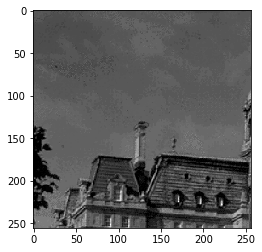

In [17]:
plt.imshow(ytest_aux[4, :, :, 0], cmap='gray')

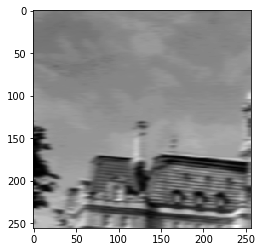

In [18]:
plt.imshow(xtest_aux[4, :, :, 0], cmap='gray')

In [19]:
# Network model
def make_autoencoder(input_shape):
  
    X_input = Input(input_shape)

    X = Conv2D(1, (2, 14), padding="same")(X_input)
    X0 = Activation('tanh')(X)
    X = BatchNormalization()(X0)
    
    X = Conv2D(4, (2, 14), padding="same")(X)
    X1 = Activation('tanh')(X)
    X = BatchNormalization()(X1)
    
    X = Conv2D(8, (2, 14), padding="same")(X)
    X2 = Activation('tanh')(X)
    X = BatchNormalization()(X2)
    
    X = Conv2D(16, (2, 14), padding="same")(X)
    X3 = Activation('tanh')(X)
    X = BatchNormalization()(X3)
 
    # Laatent space
    
    X = Conv2DTranspose(8, (2, 14), padding="same")(X)
    X = Activation('tanh')(X)
    X = BatchNormalization()(X)
    X = Add()([X2, X])
    
    X = Conv2DTranspose(4, (2, 14), padding="same")(X)
    X = Activation('tanh')(X)
    X = BatchNormalization()(X)
    X = Add()([X1, X])
    
    X = Conv2DTranspose(1, (2, 14), padding="same")(X)
    X = Activation('tanh')(X)
    X = BatchNormalization()(X)
    X = Add()([X0, X])
    
    X = Conv2DTranspose(1, (2, 14), padding="same")(X)
    X = Activation('tanh')(X)
    

    model = Model(inputs=X_input, outputs=X)
    
    return model

In [20]:
mirrored_strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

Number of devices: 2


In [21]:
opt = Adam(lr=1e-4)

In [22]:
# Training with 2 GPUs
with mirrored_strategy.scope():
    model = make_autoencoder(ytrain.shape[1:])
    model.compile(optimizer=opt, loss=custom_ssim)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 1)  29          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 1)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 1)  4           activation[0][0]                 
______________________________________________________________________________________________

In [24]:
history = model.fit(x=xtrain, y=ytrain, epochs=10000, validation_data=[xtest, ytest])

Train on 180 samples, validate on 16 samples
Epoch 1/10000
INFO:tensorflow:batch_all_reduce: 30 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 30 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
180/180 [==============================] - 10s 56ms/sample - loss: 0.9548 - val_loss: 0.9009
Epoch 2/10000
180/180 [==============================] - 1s 3ms/sample - loss: 0.9208 - val_loss: 0.8753
Epoch 3/10000
180/180 [==============================] - 1s 3ms/sample - loss: 0.8958 - val_loss: 0.8411
Epoch 4/10000
180/180 [==============================] - 1s 3ms/sample - loss: 0.8742 - val_loss: 0.8022
Epoch 5/10000
180/180 [==============================] - 1s 3ms/sample - loss: 0.8583 - val_loss: 0.7616
Epoch 6/10000
180/180 [==============================] - 1s 3ms/sample - loss: 0.8443 - val_loss: 0.7262
Epoch 7/10000
180/1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



180/180 [==============================] - 1s 6ms/sample - loss: 0.0835 - val_loss: 0.0659
Epoch 5349/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0786 - val_loss: 0.0672
Epoch 5350/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0804 - val_loss: 0.0662
Epoch 5351/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0855 - val_loss: 0.0668
Epoch 5352/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0809 - val_loss: 0.0677
Epoch 5353/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0794 - val_loss: 0.0674
Epoch 5354/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0791 - val_loss: 0.0665
Epoch 5355/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0806 - val_loss: 0.0657
Epoch 5356/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0833 - val_loss: 0.0662
Epoch 5357/10000
180/180 [===================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



180/180 [==============================] - 1s 6ms/sample - loss: 0.0754 - val_loss: 0.0607
Epoch 7472/10000
180/180 [==============================] - 1s 5ms/sample - loss: 0.0824 - val_loss: 0.0618
Epoch 7473/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0738 - val_loss: 0.0822
Epoch 7474/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0763 - val_loss: 0.0677
Epoch 7475/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0791 - val_loss: 0.0635
Epoch 7476/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0743 - val_loss: 0.0610
Epoch 7477/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0771 - val_loss: 0.0688
Epoch 7478/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0777 - val_loss: 0.0642
Epoch 7479/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0795 - val_loss: 0.0611
Epoch 7480/10000
180/180 [===================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



180/180 [==============================] - 1s 6ms/sample - loss: 0.0736 - val_loss: 0.0579
Epoch 9568/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0741 - val_loss: 0.0593
Epoch 9569/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0771 - val_loss: 0.0572
Epoch 9570/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0752 - val_loss: 0.0607
Epoch 9571/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0774 - val_loss: 0.0585
Epoch 9572/10000
180/180 [==============================] - 1s 5ms/sample - loss: 0.0733 - val_loss: 0.0869
Epoch 9573/10000
180/180 [==============================] - 1s 5ms/sample - loss: 0.0707 - val_loss: 0.0675
Epoch 9574/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0780 - val_loss: 0.0581
Epoch 9575/10000
180/180 [==============================] - 1s 6ms/sample - loss: 0.0735 - val_loss: 0.0582
Epoch 9576/10000
180/180 [===================

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


dict_keys(['loss', 'val_loss'])


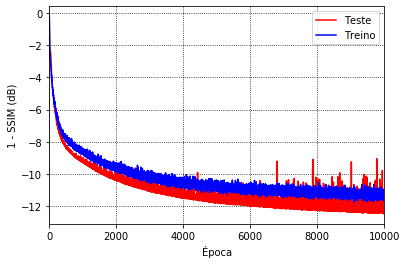

In [25]:
# Plotting loss
plt.plot(10*np.log10(history.history['val_loss']), 'r', label='Teste')
plt.plot(10*np.log10(history.history['loss']), 'b', label='Treino')
plt.legend(loc='upper right')
plt.xlim(0, 10000)
plt.grid(color='black', linestyle='dotted')
plt.ylabel('1 - SSIM (dB)')
plt.xlabel('Época')
plt.savefig('saved/residual_ssim_sigma3_(2, 14)/error.eps', format='eps')
plt.show()

In [29]:
# Saving model
model.save('saved/residual_ssim_sigma3_(2, 14)/model.h5')